[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/Allison/blob/develop/examples/regression/2-logistic-regression.ipynb)

In [1]:
!pip install "allison @ git+https://github.com/Mitchell-Mirano/Allison.git@develop"

zsh:1: command not found: pip


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import allison
from allison.datasets import train_test_split
from allison.metrics import classification_report, confusion_matrix
from allison.nn import Linear, BCEWithLogitsLoss
from allison.optim import RMSprop, Adam

In [4]:
device = 'gpu' if allison.cuda.is_available() else 'cpu'
device

❌ CuPy is not installed.


'cpu'

In [5]:
data=pd.read_csv("../data/Iris.csv")
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
data['Species'].unique()
data = data[data['Species'].isin(['Iris-setosa', 'Iris-versicolor'])]
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
95,96,5.7,3.0,4.2,1.2,Iris-versicolor
96,97,5.7,2.9,4.2,1.3,Iris-versicolor
97,98,6.2,2.9,4.3,1.3,Iris-versicolor
98,99,5.1,2.5,3.0,1.1,Iris-versicolor


In [7]:
labels2id = {label: i for i, label in enumerate(data['Species'].unique())}
id2labels = {i: label for i, label in enumerate(data['Species'].unique())}

In [8]:
data['labels']=data['Species'].map(labels2id)
data = data[data['labels'].isin([0,1])]
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,labels
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,0
2,3,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0


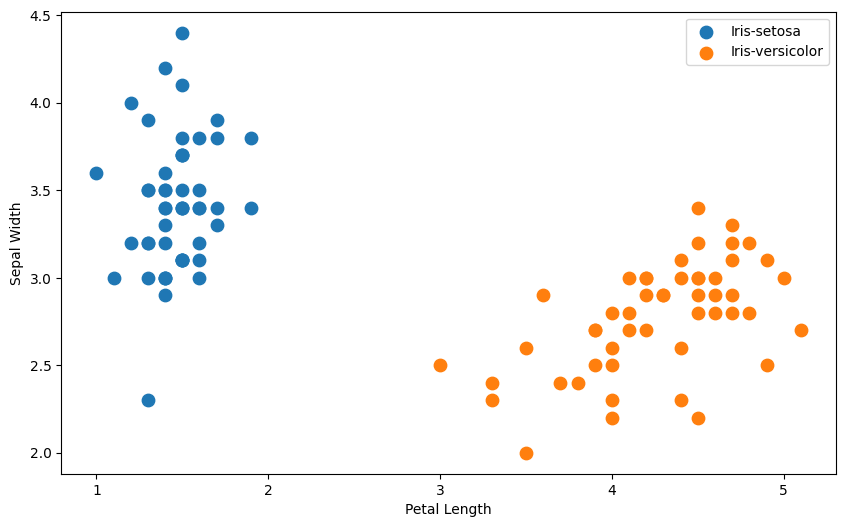

In [9]:
plt.figure(figsize=(10,6))
for specie in data['Species'].unique():
    specie_data = data[data['Species'] == specie]
    plt.scatter(specie_data['PetalLengthCm'],specie_data['SepalWidthCm'],s=80 ,label=specie )
    plt.legend()
    plt.xlabel("Petal Length")
    plt.ylabel("Sepal Width")

In [10]:
independent_features=['PetalLengthCm','SepalWidthCm','PetalWidthCm','SepalLengthCm']
dependent_feature=['labels']

In [11]:

data_train,data_test=train_test_split(data,test_size=0.2)

X_train=allison.tensor(data_train[independent_features],device=device)
Y_train=allison.tensor(data_train[dependent_feature],device=device)

X_test=allison.tensor(data_test[independent_features],device=device)
Y_test=allison.tensor(data_test[dependent_feature],device=device)

X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((80, 4), (80, 1), (20, 4), (20, 1))

In [12]:
model = Linear(4, 1).to(device)

loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.01)


In [13]:
for epoch in range(1000+1):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f}")

Epoch: 0 | Loss: 1.6742
Epoch: 100 | Loss: 0.2143
Epoch: 200 | Loss: 0.1048
Epoch: 300 | Loss: 0.0634
Epoch: 400 | Loss: 0.0433
Epoch: 500 | Loss: 0.0319
Epoch: 600 | Loss: 0.0247
Epoch: 700 | Loss: 0.0198
Epoch: 800 | Loss: 0.0163
Epoch: 900 | Loss: 0.0137
Epoch: 1000 | Loss: 0.0117


TypeError: tensor.__array__() takes 1 positional argument but 2 were given

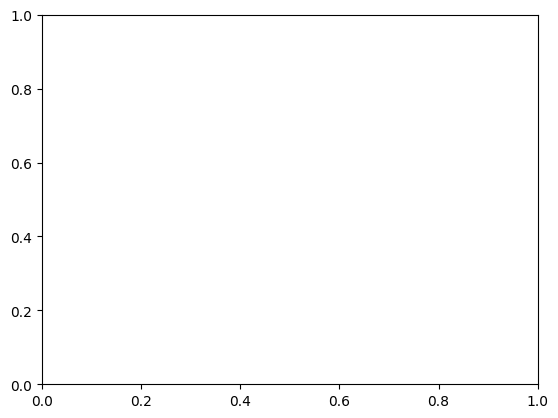

In [14]:
with allison.no_grad():
    logits = model(X_test)
probs = allison.sigmoid(logits)
preds = (probs > 0.5).astype('uint8')
acc_test = (preds == Y_test).mean()
plt.scatter(X_test[:,0],X_test[:,1],c=preds)
plt.title(f"Logistic Regression on Test Data(Accuracy:{100*acc_test.item():.2f}%)")
plt.show()

# Save Model

In [15]:
import joblib

In [16]:
joblib.dump(model.to('cpu'), 'logistic_model.joblib')

['logistic_model.joblib']

In [17]:
model2 = joblib.load('logistic_model.joblib')
print(type(model2.coef_),type(model2.intercept_))
model2.to(device)
print(type(model2.coef_),type(model2.intercept_))

<class 'numpy.ndarray'> <class 'float'>
<class 'numpy.ndarray'> <class 'float'>


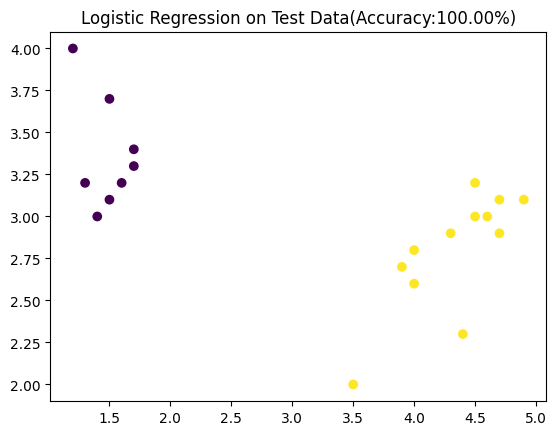

In [18]:
with allison.no_grad():
    logits = model2(X_test)
probs = allison.sigmoid(logits)
preds = (probs.data > 0.5).astype('uint8')
acc_test = (preds == Y_test.data).mean()
preds = preds.get() if device == 'gpu' else preds

plt.scatter(X_test[:,0],X_test[:,1],c=preds)
plt.title(f"Logistic Regression on Test Data(Accuracy:{100*acc_test:.2f}%)")
plt.show()